Notebook to post-process and plot p-class cluster results for Rosi's MPAS aquaplanet grid.

Write-out is done by mpas_pclass_cluster_write.ipynb

James Ruppert  
9/1/2025

### Main settings

In [1]:
import xarray as xr
import numpy as np
import dask.array as da
import pickle
import matplotlib.pyplot as plt

In [2]:
do_process_clusters = False
# do_process_clusters = True

# pickle_path_write = "../../../pickle_out/aquaplanet"
pickle_path_write = "/glade/derecho/scratch/ruppert/tc-crfrad/pickle_out"

exp_names = ["CTL","HOMO_RAD","CLIM_RAD"]
ntest = len(exp_names)
pclass_names = ['DC', 'CG', 'SC', 'ST', 'AN', 'DSA']
pclass_names_long = ['DeepC', 'Congest', 'Shallow', 'Stratiform', 'Anvil', 'DSA']
nclass = len(pclass_names)

### Main driver loop

#### Functions

In [3]:
def latitude_masking(labels_in, latitudes, latbounds):
    labels_filtered = labels_in.copy()
    mask_outside = np.where((latitudes < latbounds[0]) | (latitudes > latbounds[1]))[0]
    labels_filtered[mask_outside] = 0
    return labels_filtered

In [4]:
# Set latitude bounds
def subset_settings(isubset=0):

    nsubset = 4

    latbounds_all = [
        [0, 15.0],
        [10, 20.0],
        [15, 20.0],
    ]

    if isubset < 3:
        global_subset = True
        latbounds = latbounds_all[isubset]
    else:
        global_subset = False
        latbounds = None

    subset_tags = []
    for isubset in range(nsubset):

        if isubset < 3:
            subset_tags.append(f"({str(latbounds_all[isubset][0])}-{str(int(latbounds_all[isubset][1]))}N)")
        else:
            subset_tags.append("Global")

    return nsubset, subset_tags, latbounds, global_subset

In [5]:
# Get list of desired file times

file_times_arr = np.arange('2000-05-01T06:00:00', '2000-05-11T06:00:00', 6, dtype='datetime64[h]')
file_times = [file_times_arr[i].astype('datetime64[D]').astype(str)+'_'+str(file_times_arr[i]).split('T')[1].split(':')[0]+'.00.00' for i in range(len(file_times_arr))]
ntime = len(file_times)

#### Start loops

In [6]:
# %%time

pickle_file_out = f"{pickle_path_write}/pclass_cluster_all.pickle"
pickle_path_read = "/glade/derecho/scratch/ruppert/tc-crfrad/mpas"

if do_process_clusters:

    # Grid info

    grid_path = "/glade/work/rberrios/MPAS/aqua_sstmax10N_ASD/plus4K/TC_3km/x5.tropical_3km_10N.init.nc"
    grid = xr.open_dataset(grid_path)
    areaCell = grid.areaCell
    ncell = areaCell.shape[0] # m^2

    latCell = np.degrees(grid.latCell)
    lonCell = np.degrees(grid.lonCell)

    # Read pickled cluster data, compute statistics

    # Get nsubset
    nsubset, subset_tags, latbounds, global_subset = subset_settings()

    numbers = np.zeros((nsubset, ntest, ntime, nclass))
    # mean_sizes = np.zeros((ntest, ntime, ncell, nclass))
    mean_sizes = np.zeros((nsubset, ntest, ntime, nclass))

    for itest, expName in enumerate(exp_names):
    # for itest, expName in enumerate(exp_names[0:1]):

        for it, time in enumerate(file_times):
        # for it, time in enumerate(file_times[5:6]):

            # Read pickles
            pickle_file_in = f"{pickle_path_read}/{expName}/pclass_cluster_{expName}_{time}.pickle"
            with open(pickle_file_in, 'rb') as f:
                lists = pickle.load(f)

            # Object count
            # numbers[itest, it, :] = lists[1]

            for isubset in range(nsubset):

                # Get latitude bounds
                nsubset, subset_tags, latbounds, global_subset = subset_settings(isubset)

                for iclass in range(nclass):
                    labels_write = np.copy(lists[0][iclass])
                    if global_subset:
                        # Mask objects that go out of selected latitude bounds
                        labels_write = latitude_masking(labels_write, latCell, latbounds)
                    # assume labels_write has the same shape as cellarea
                    unique_labels = np.unique(labels_write)
                    # ignore background/no-label
                    unique_labels = unique_labels[unique_labels >= 1]
                    # compute weighted cluster size
                    cluster_area = np.bincount(labels_write, weights=areaCell)
                    # restrict to valid labels only
                    cluster_area = cluster_area[unique_labels]
                    mean_sizes[isubset, itest, it, iclass] = np.sqrt(np.mean(cluster_area)) # m^2 --> m
                    # Update object counts, just in case
                    numbers[isubset, itest, it, iclass] = len(unique_labels)

            print(f"Finished processing {expName} {time}")

        print(f"Finished processing {expName}")

    print('Processing complete.')

    # Write out to pickle
    with open(pickle_file_out, 'wb') as f:
        pickle.dump([subset_tags, numbers, mean_sizes], f)

else:

    # Read from pickle
    with open(pickle_file_out, 'rb') as f:
        arrays = pickle.load(f)

    subset_tags = arrays[0]
    numbers = arrays[1]
    mean_sizes = arrays[2]

In [7]:
# file_times_arr = np.arange('2000-05-01T06:00:00', '2000-05-11T06:00:00', 6, dtype='datetime64[h]')
# file_times = [file_times_arr[i].astype('datetime64[D]').astype(str)+'_'+str(file_times_arr[i]).split('T')[1].split(':')[0]+'.00.00' for i in range(len(file_times_arr))]
# ntime = len(file_times)

# # grid_path = "/glade/work/rberrios/MPAS/aqua_sstmax10N_ASD/plus4K/TC_3km/x5.tropical_3km_10N.init.nc"
# # grid = xr.open_dataset(grid_path)
# # areaCell = grid.areaCell

# # Read pickles
# pickle_file_in = f"{pickle_path_read}/{exp_names[0]}/pclass_cluster_{exp_names[0]}_{file_times[5]}.pickle"
# with open(pickle_file_in, 'rb') as f:
#     lists = pickle.load(f)

# iclass = 1
# labels_write = lists[0][iclass]
# # if global_subset:
# #     # Mask objects that go out of selected latitude bounds
# #     labels_write = latitude_masking(labels_write, latCell, latbounds)
# # assume labels_write has the same shape as cellarea
# unique_labels = np.unique(labels_write)
# # ignore background/no-label
# unique_labels = unique_labels[unique_labels >= 1]
# # compute weighted cluster size
# # cluster_area = np.bincount(labels_write, weights=areaCell)
# # # restrict to valid labels only
# # cluster_area = cluster_area[unique_labels]
# # mean_sizes[itest, it, iclass] = np.sqrt(np.mean(cluster_area)) # m^2 --> m
# # numbers[itest, it, iclass] = len(unique_labels)


### Plotting

#### Test latitude masking and plotting of clusters

In [16]:
# # Test latitude masking and plotting of clusters

# # Read pickles
# figname = f"test_clusters_{exp_names[0]}_it20.png"
# pickle_file_in = f"{pickle_path_read}/{exp_names[0]}/pclass_cluster_{exp_names[0]}_{file_times[20]}.pickle"
# with open(pickle_file_in, 'rb') as f:
#     lists = pickle.load(f)

# grid_path = "/glade/work/rberrios/MPAS/aqua_sstmax10N_ASD/plus4K/TC_3km/x5.tropical_3km_10N.init.nc"
# grid = xr.open_dataset(grid_path)
# # areaCell = grid.areaCell
# latCell = np.degrees(grid.latCell)
# lonCell = np.degrees(grid.lonCell)

# iclass=0
# labels_write = lists[0][iclass]
# # # Mask objects that go out of selected latitude bounds
# # # labels_filtered, indices_inside = latitude_masking(labels_write, latCell, latbounds)
# # # assume labels_write has the same shape as cellarea
# # unique_labels = np.unique(labels_filtered)
# # # ignore background/no-label
# # unique_labels = unique_labels[unique_labels >= 1]
# # # compute weighted cluster size
# # cluster_area = np.bincount(labels_filtered, weights=areaCell[indices_inside])
# # # restrict to valid labels only
# # cluster_area = cluster_area[unique_labels]

# labels_masked = np.ma.masked_where(labels_write == 0, labels_write)
# fig = plt.figure(figsize=(12,10))
# fig.set_facecolor('white')
# ax = fig.add_subplot(211)#, aspect='equal')
# sc = ax.scatter(lonCell, latCell, c=labels_masked, cmap="tab20", s=2, marker="s")
# # ax.set_title("Clusters (N = "+str(nfeat)+")")
# # ax.set_xlabel('[km]')
# # ax.set_ylabel('[km]')
# # latbounds = [-5, 20.0]
# # ind_within_lat = np.where( (latCell >= latbounds[0]) & (latCell <= latbounds[1]) )[0]
# # plt.ylim((np.min(latCell[ind_within_lat]), np.max(latCell[ind_within_lat])))
# plt.ylim([-5,20])
# # plt.tight_layout()
# plt.show()
# plt.savefig(figname, dpi=200)
# # plt.text(500,1750, 'Total = '+str(num_features))
# # return None

#### Box plots

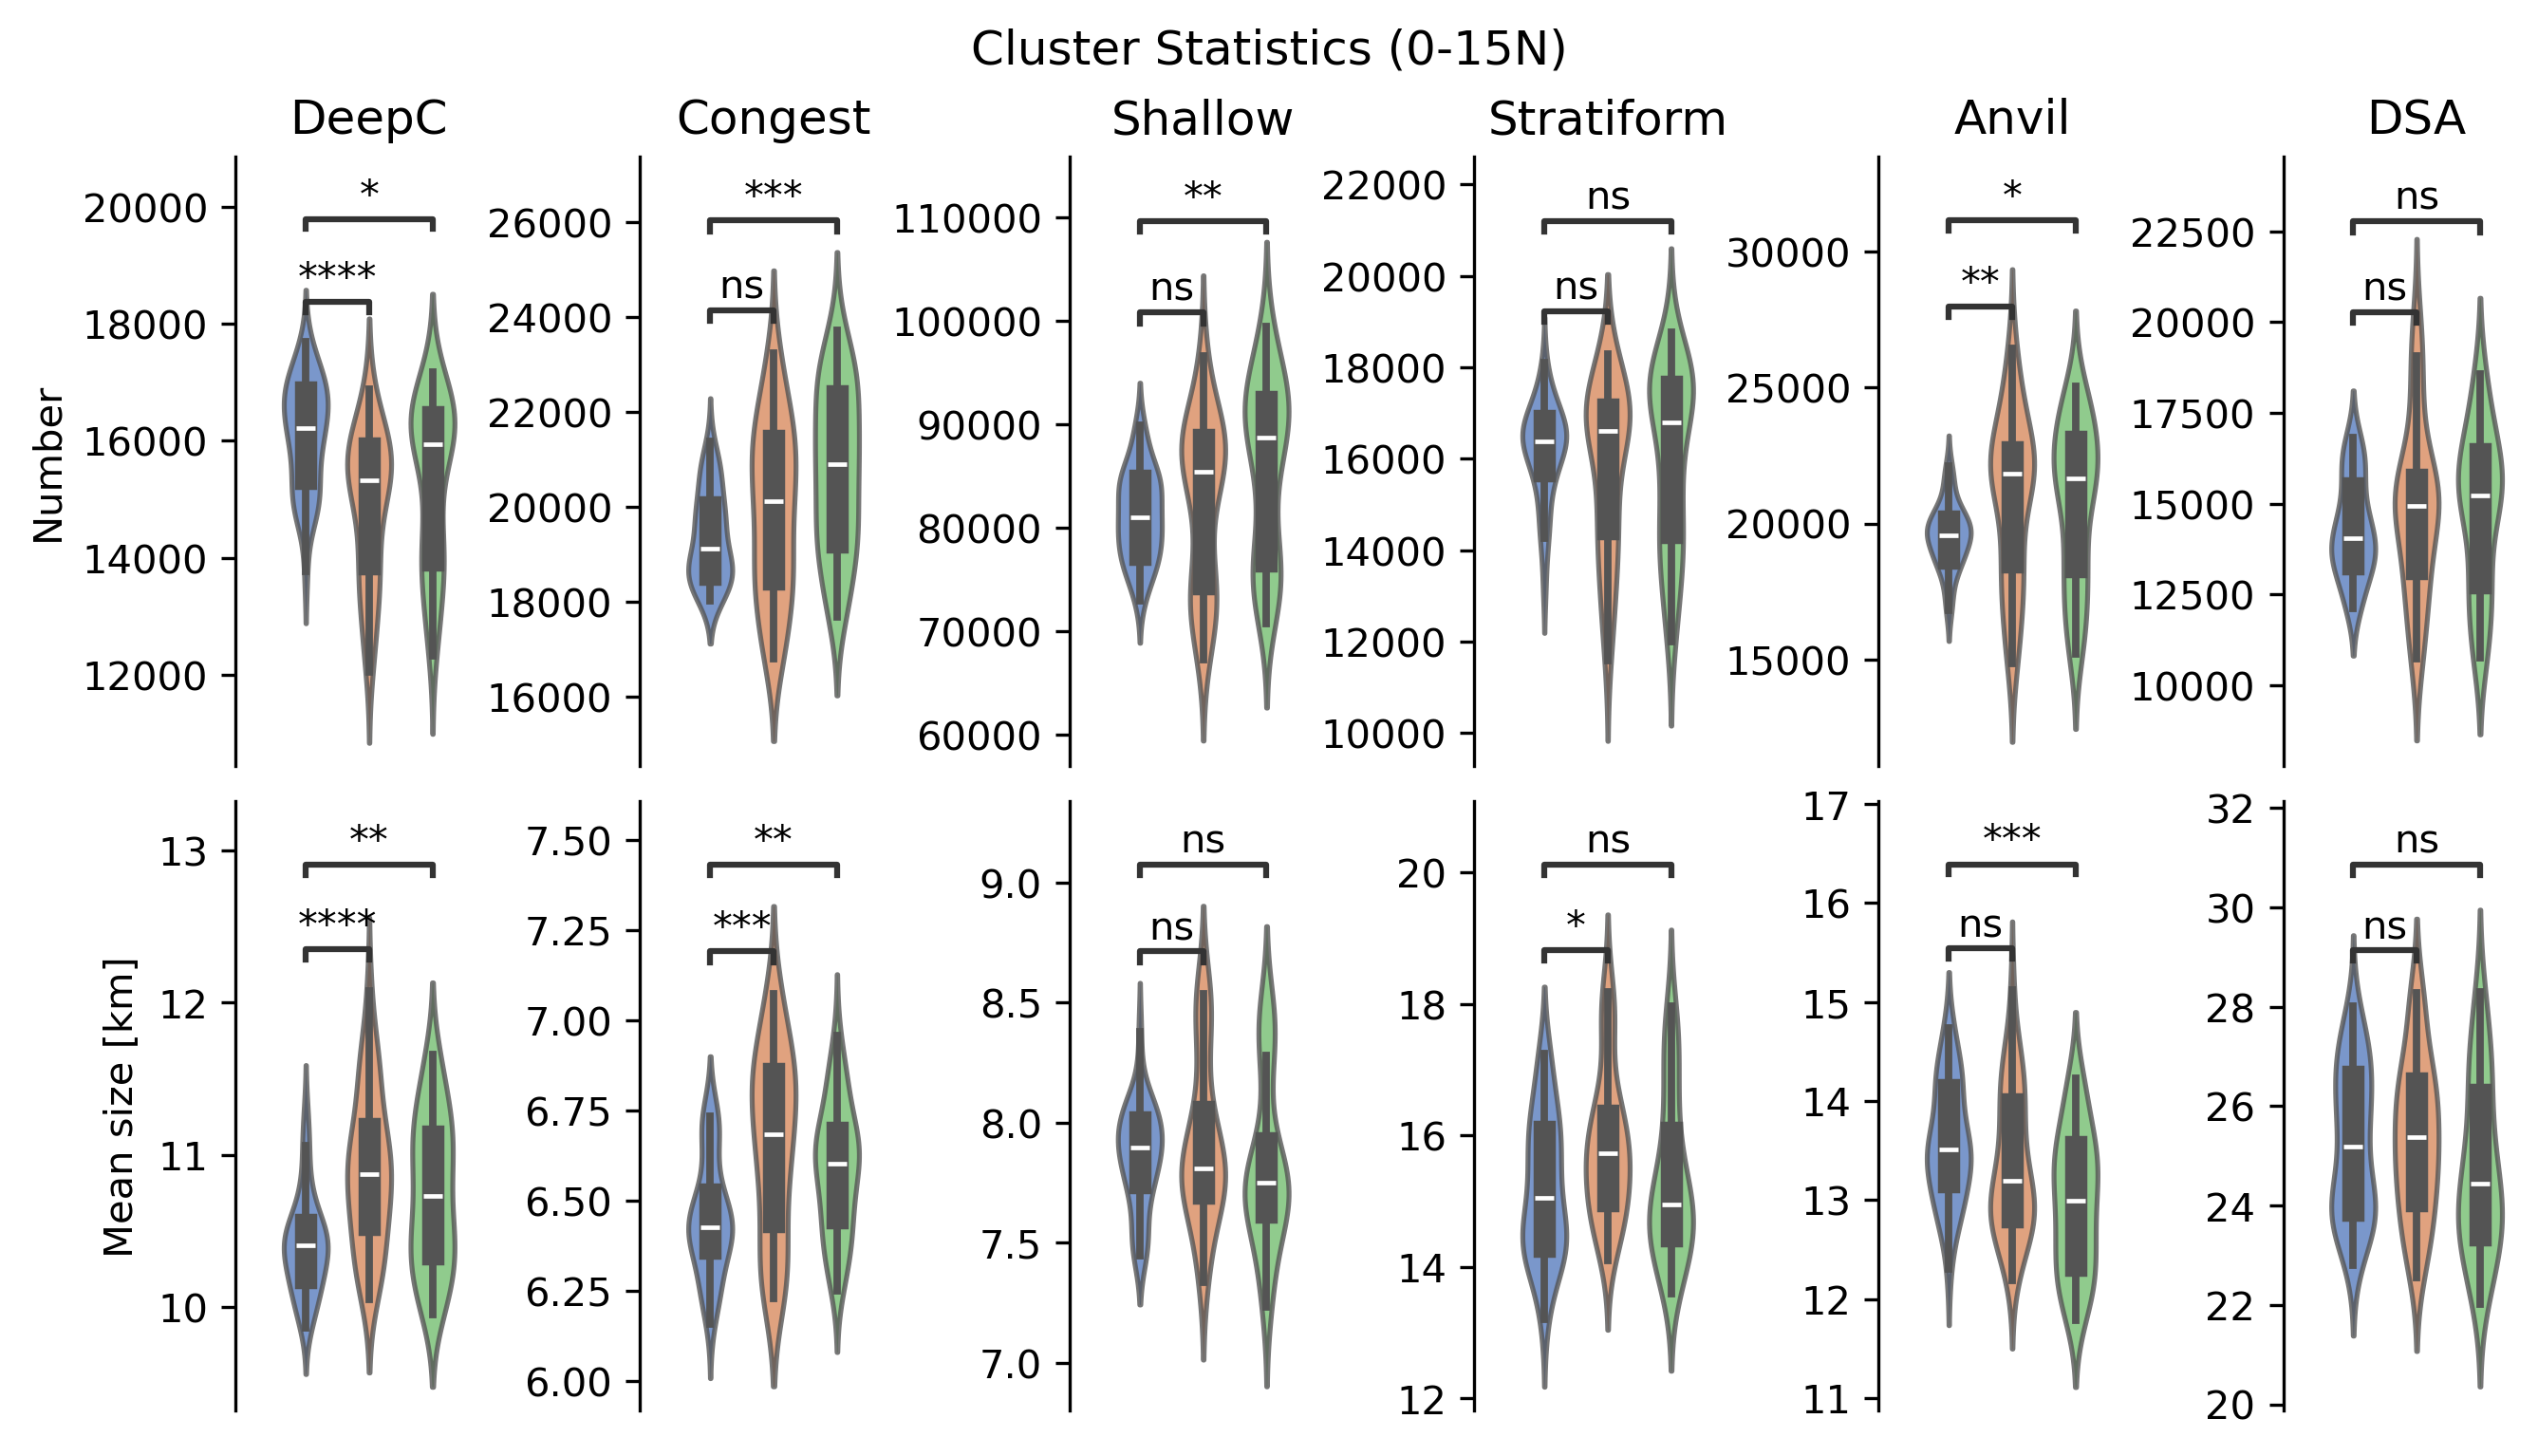

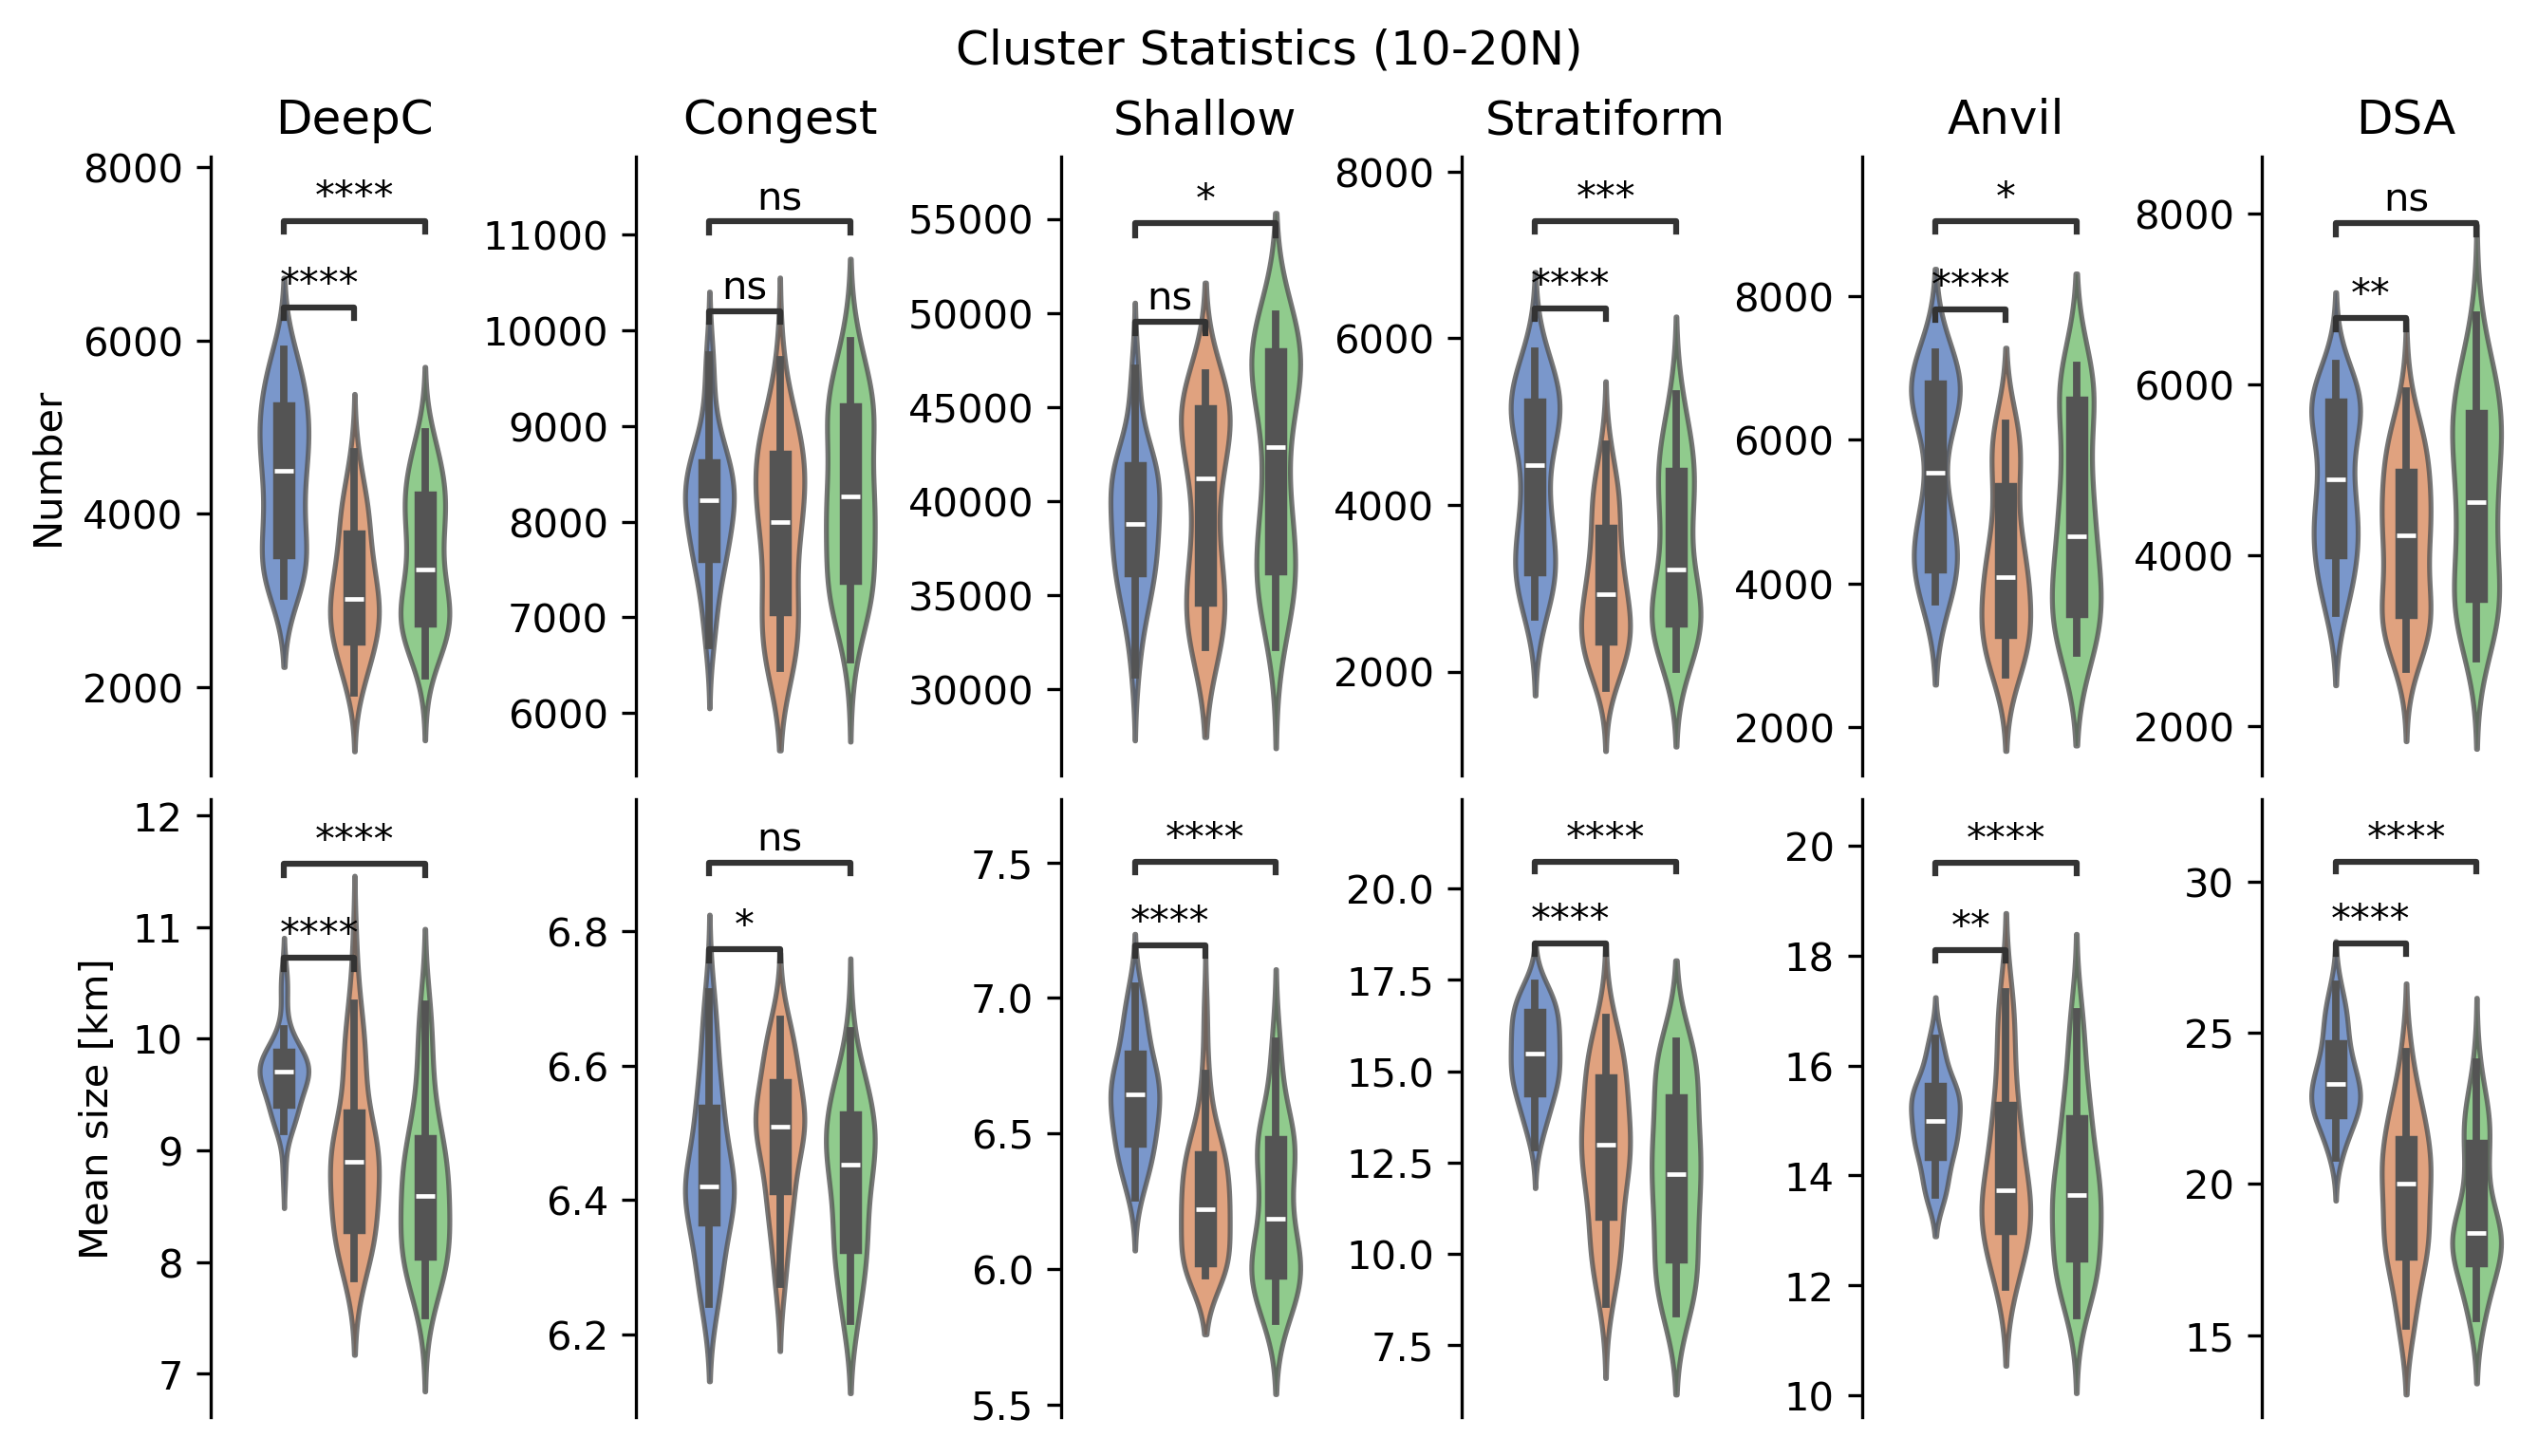

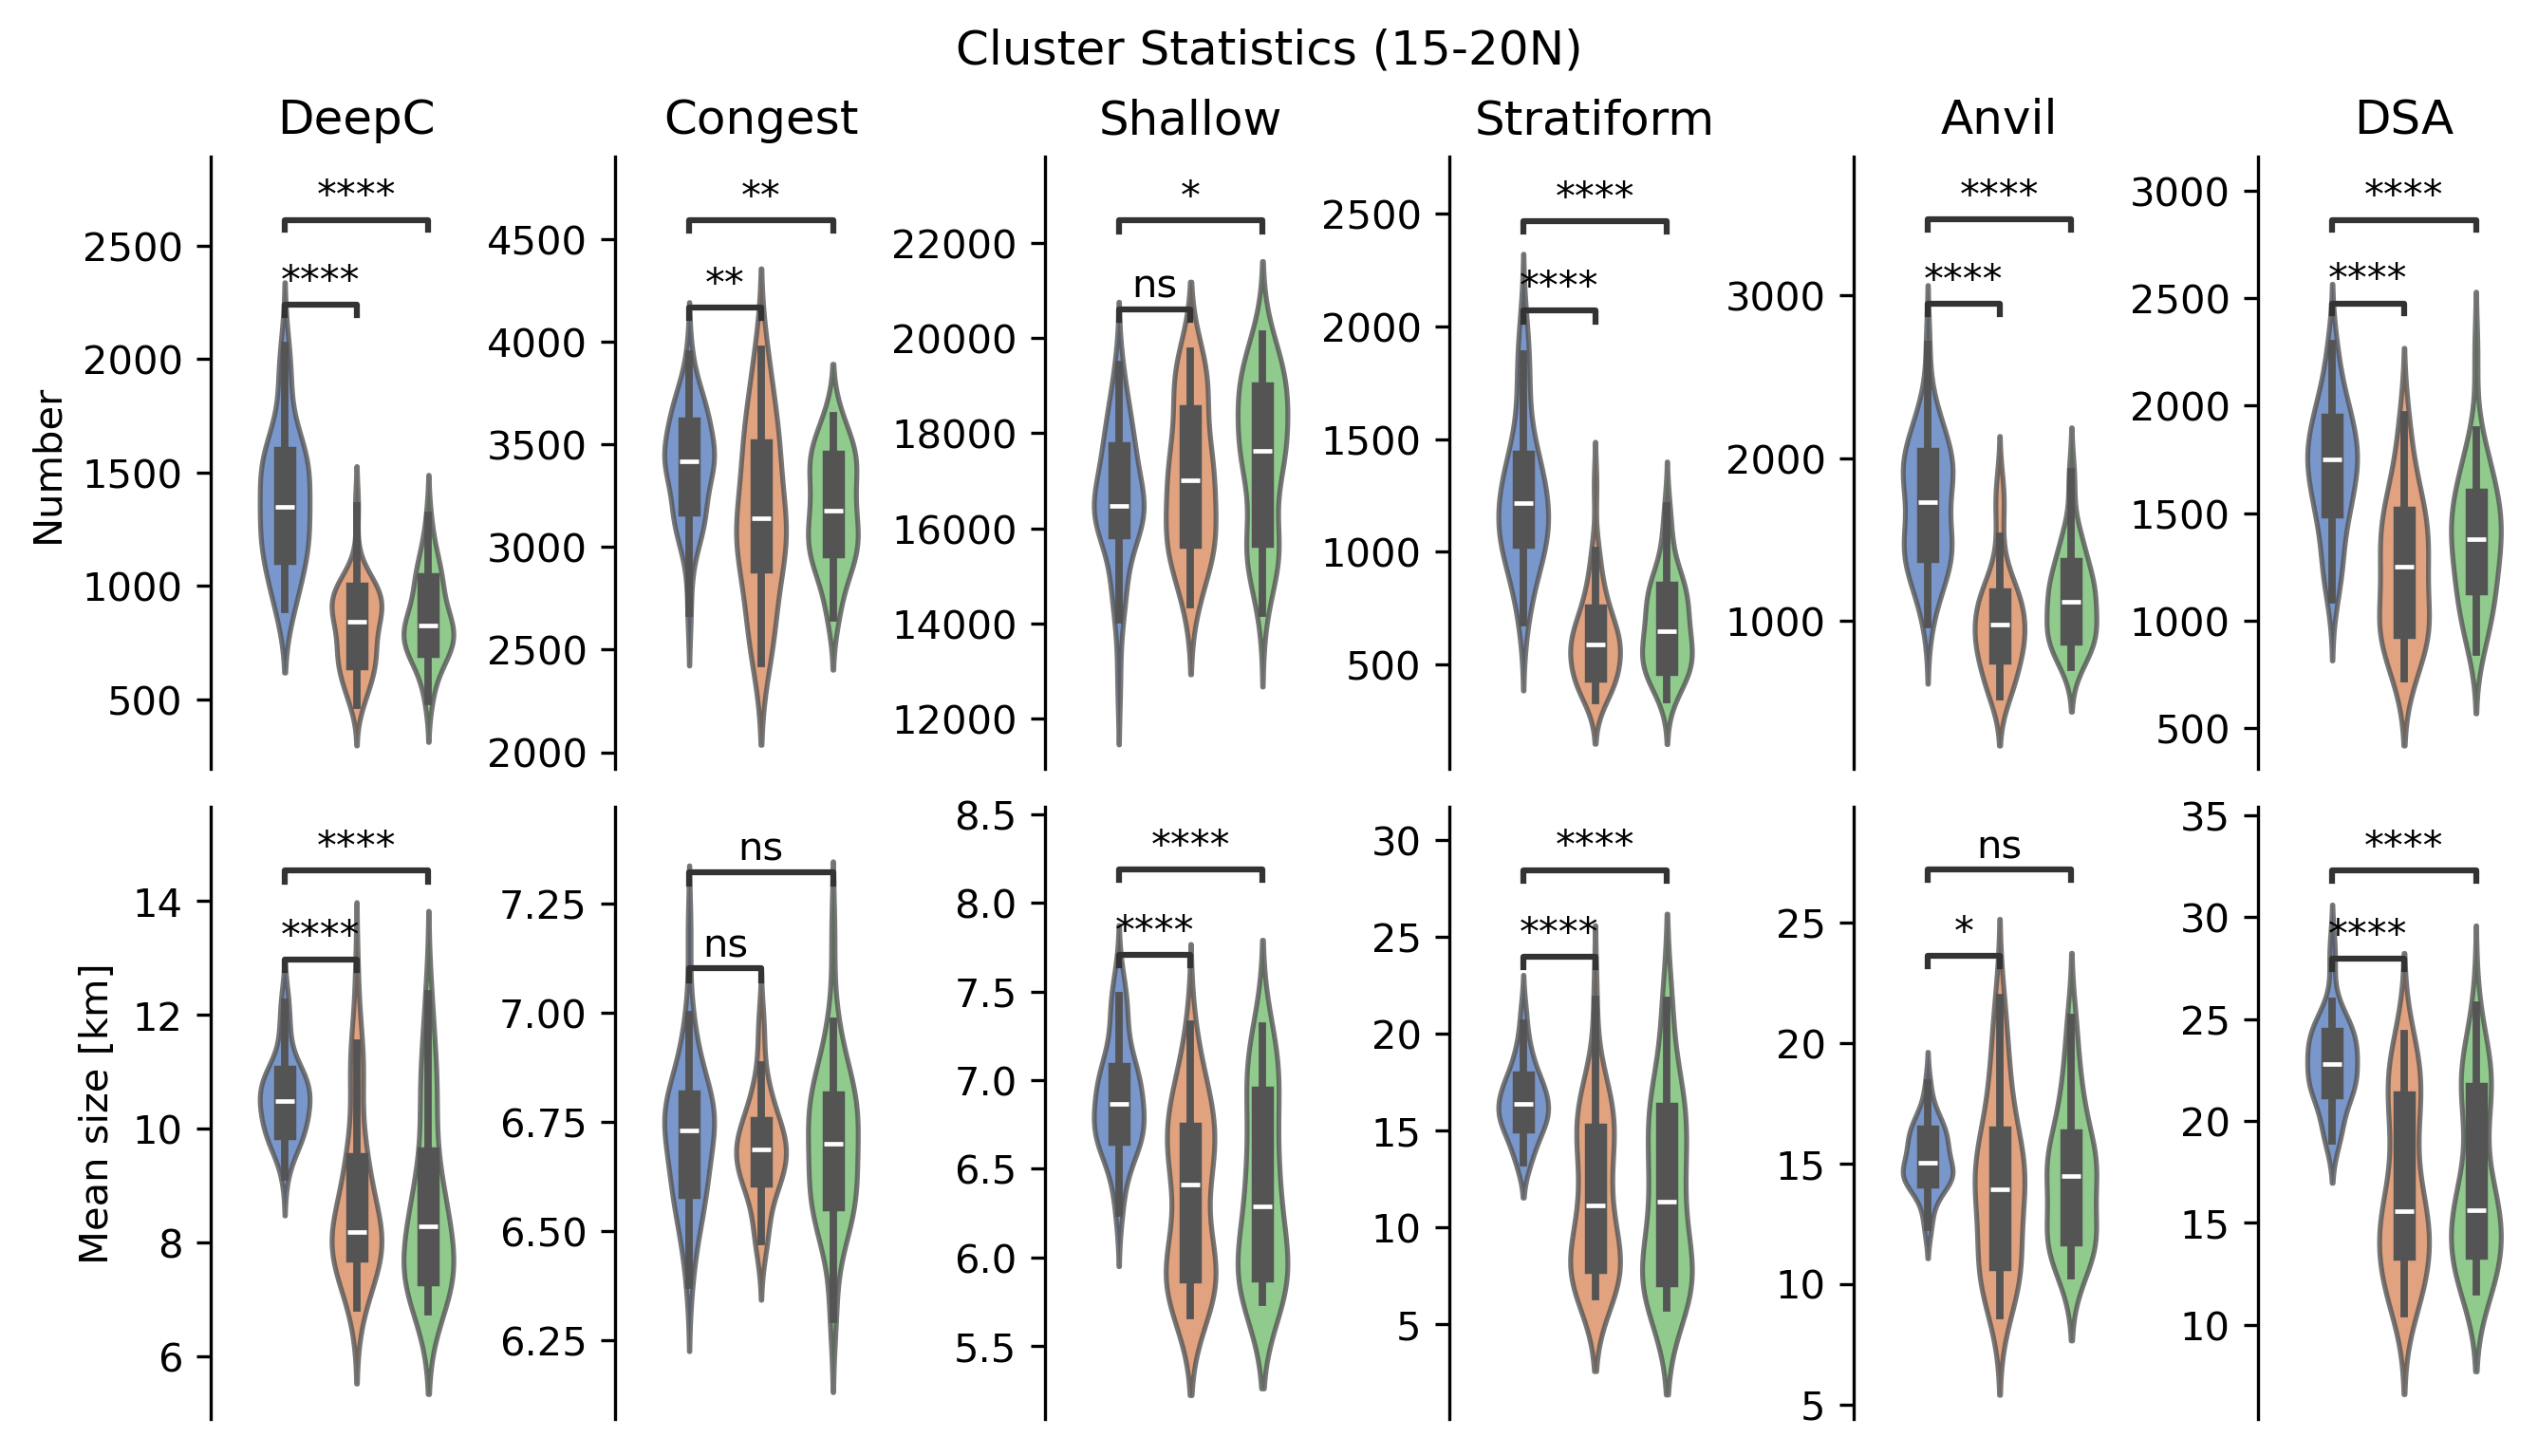

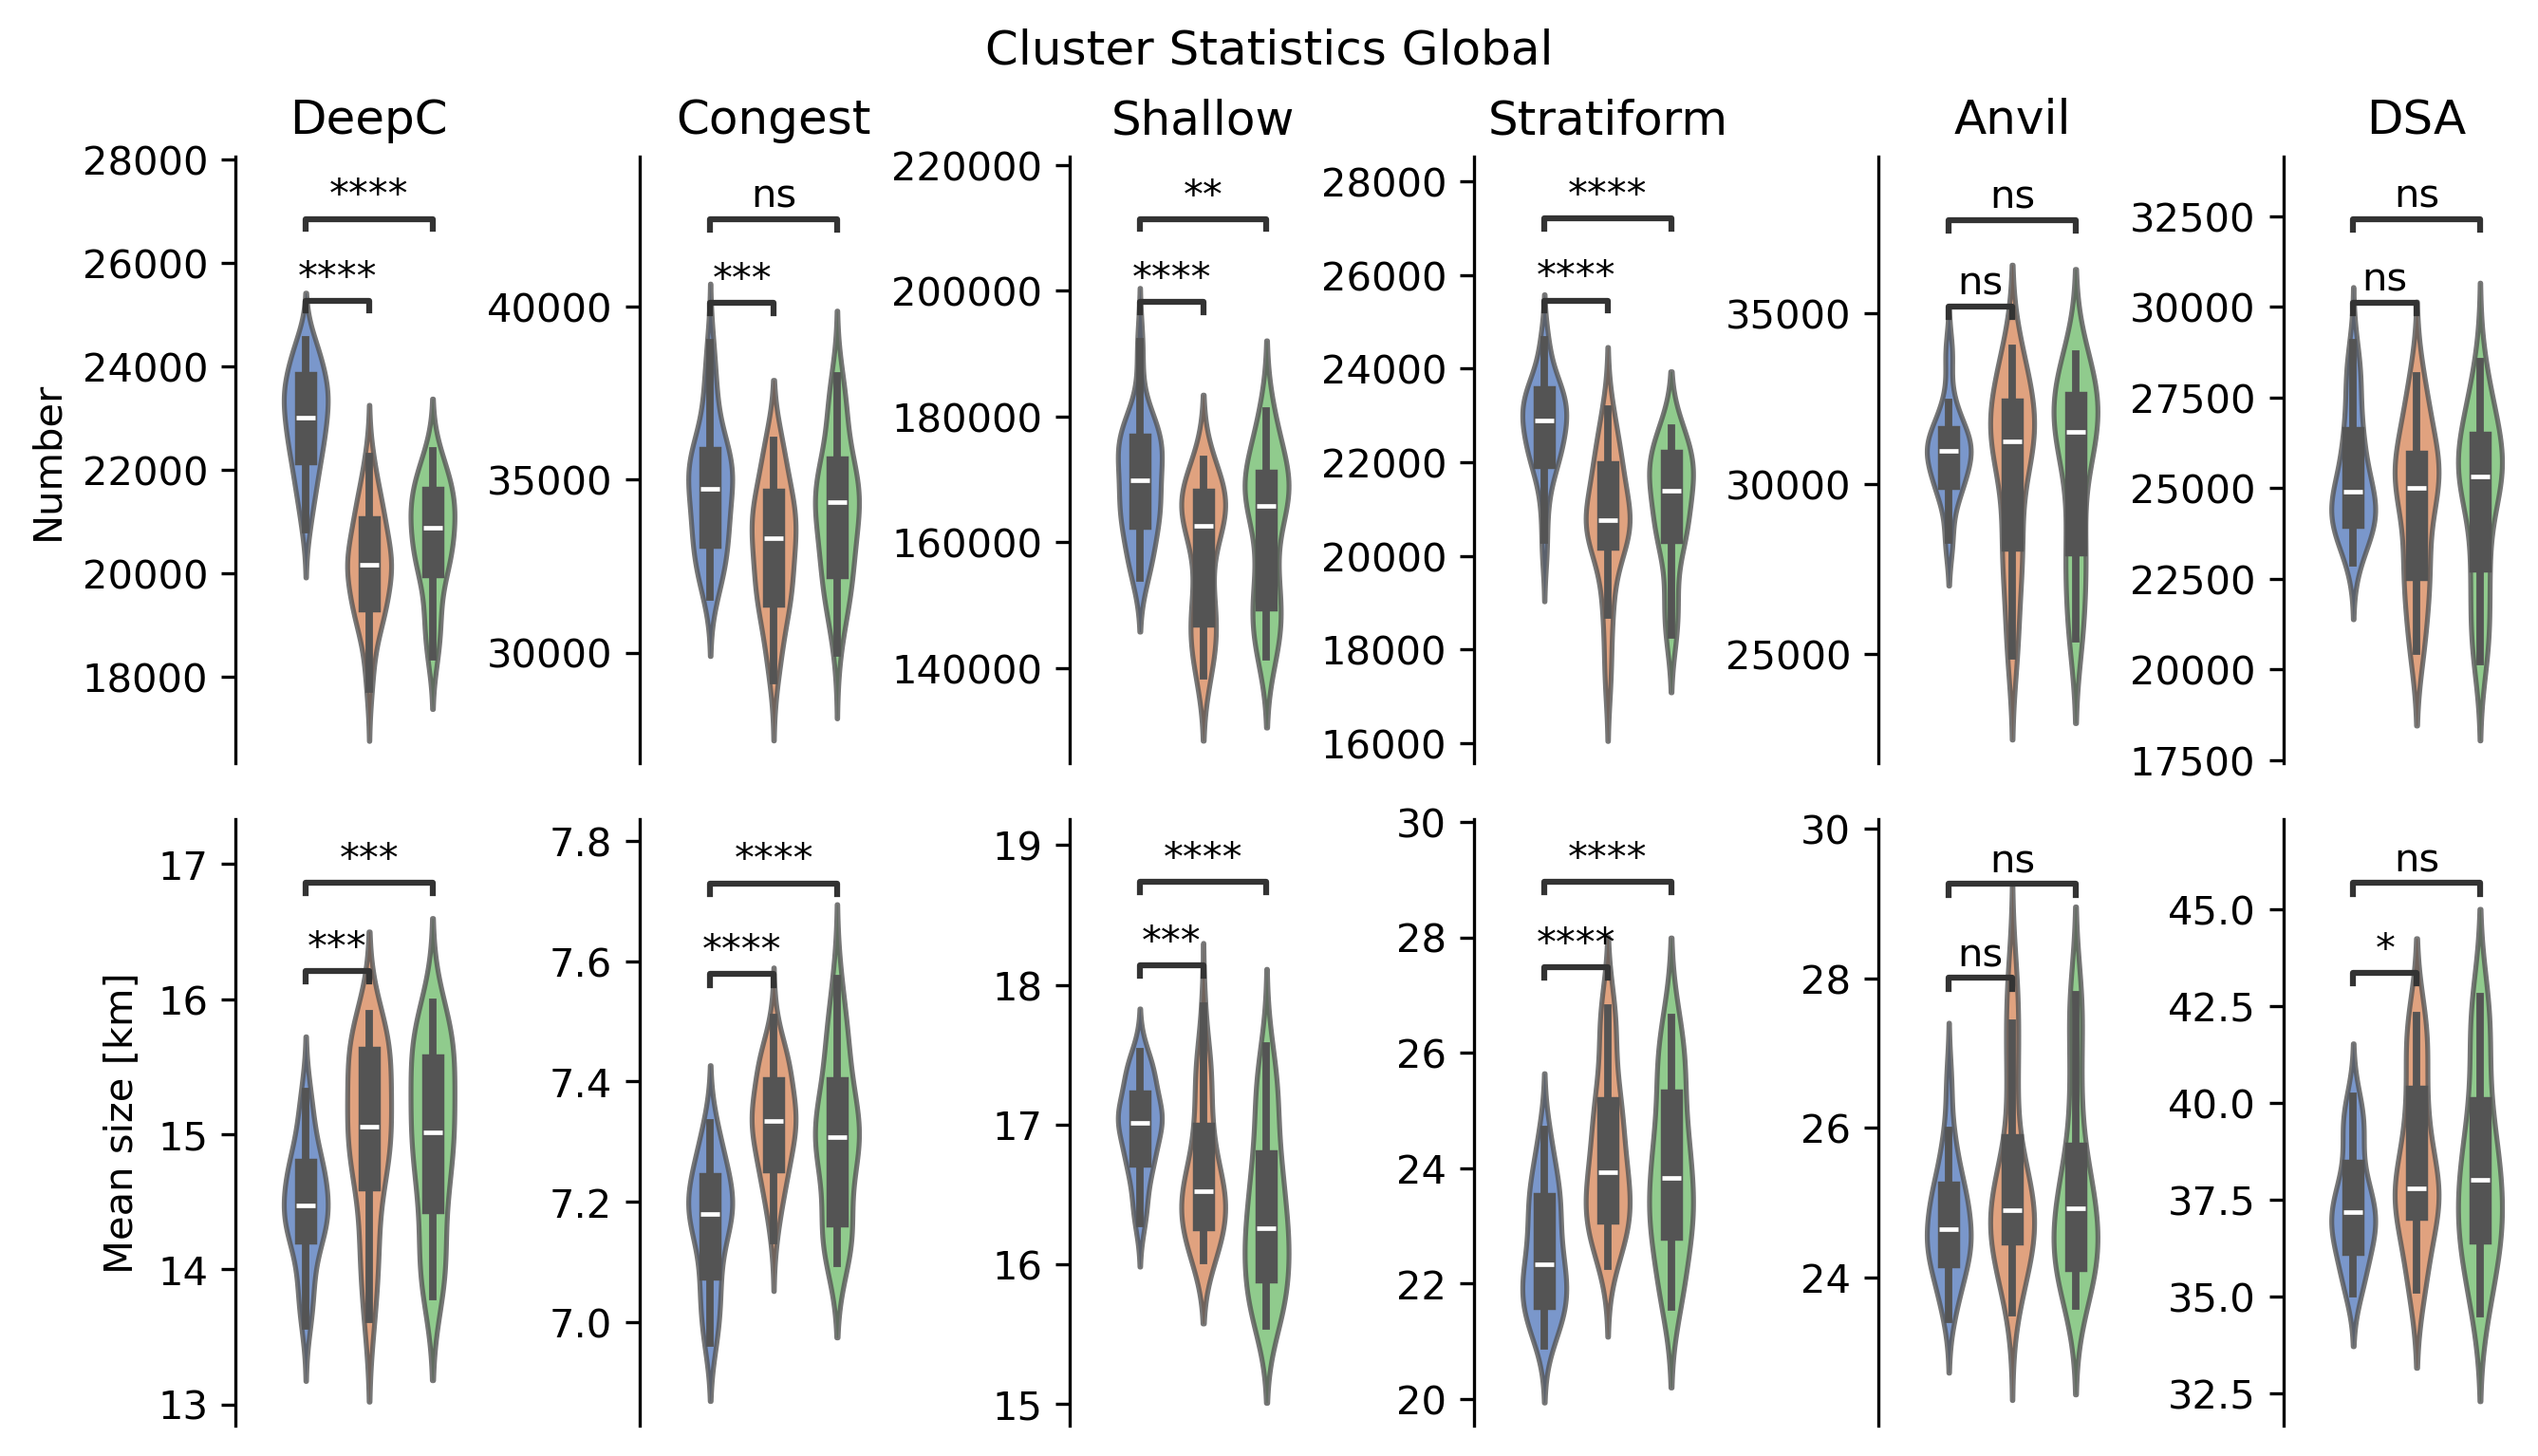

In [19]:
from scipy.stats import ttest_ind
import seaborn as sns
from statannotations.Annotator import Annotator

def plot_boxplots(pltvar, axs, do_legend=False):
      colors = sns.color_palette('muted', n_colors=ntest)
      for iclass, iax in enumerate(axs):
            # sns.boxplot([pltvar[iexp,:,iclass] for iexp in range(pltvar.shape[0])],
            #             width=0.7, showmeans=True,
            #             meanprops={"marker":"o", "markerfacecolor":"white",
            #                   "markeredgecolor":"black", "markersize":"6"},
            #             palette=colors,
            #             ax=iax, notch=True, showcaps=False, bootstrap=10000,
            #             showfliers=True,)
            sns.violinplot([pltvar[iexp,:,iclass] for iexp in range(pltvar.shape[0])],
                           width=0.7,
                           palette=colors, alpha=0.8,
                           inner="box", #split=True,
                           gap=0.01,
                           ax=iax)
            sns.despine(ax=iax, bottom=True)

            # Add t-test
            # t_stat, p_value = ttest_ind(pltvar[0,:,iclass],
            #                         pltvar[1,:,iclass],
            #                         equal_var=True)
            # iax.text(0.5, -0.11, str(np.round(p_value, 3)),
            #          ha='center', va='top', transform=iax.transAxes)#, fontsize=10)
            # Annotate with significance
            pairs = [(0, 1), (0, 2)]
            annotator = Annotator(iax, pairs, data=[pltvar[iexp,:,iclass] for iexp in range(pltvar.shape[0])])
            annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
            annotator.apply_and_annotate()

      # if do_legend:
      #       axs[-1].legend(loc="upper right", frameon=False, fontsize=12, labels=test_names, bbox_to_anchor=(1.15, 0.5))
      #       handles = [plt.Line2D([0], [0], color=colors[i], lw=10) for i in range(ntest)]
      #       axs[-1].legend(handles=handles, labels=test_names, loc="center right", frameon=False,
      #                      fontsize=12, bbox_to_anchor=(5.0, 0.5))
      return axs

nsubset, subset_tags, latbounds, global_subset = subset_settings()

for isubset in range(nsubset):

      # Get latitude bounds
      nsubset, subset_tags, latbounds, global_subset = subset_settings(isubset)

      # create figure
      fig_x = 1.3*nclass + 1
      fig_y = 5
      fig, axs = plt.subplots(2,nclass, figsize=(fig_x,fig_y), layout="constrained", dpi=300)

      title = f"Cluster Statistics {subset_tags[isubset]}"
      fig.suptitle(title)

      # Cluster counts
      pltvar = numbers[isubset]
      ytitle = 'Number'
      irow = 0
      axs[irow, 0].set_ylabel(ytitle)
      # plot_boxplots(pltvar, axs.flatten()[0:nclass], ntest, it_max, ytitle, do_legend=True)
      axs[irow,:] = plot_boxplots(pltvar[:,:,:], axs[irow,:])

      # Cluster sizes
      pltvar = mean_sizes[isubset]/1e3 # m --> km
      ytitle = 'Mean size [km]'
      # plot_boxplots(pltvar, axs.flatten()[nclass:nclass*2], ntest, it_max, ytitle, do_legend=True)
      irow = 1
      axs[irow, 0].set_ylabel(ytitle)
      axs[irow,:] = plot_boxplots(pltvar[:,:,:], axs[irow,:])

      for iclass in range(nclass):
            axs[0,iclass].set_title(pclass_names_long[iclass])

      for iaxs in axs.flatten():
            sns.despine(offset=10,ax=iaxs, top=True, right=True, bottom=True)
            iaxs.set_xticks([])

      # axs[1,nclass-1].legend(loc="upper right", labels=test_names,
      #                        frameon=False, fontsize=12, bbox_to_anchor=(1.15, 0.5))

      plt.show()
      plt.close()

#### Time series

In [9]:
# def do_tser(figdata, do_legend=False):
#     ntest = figdata['number'].shape[0]
#     smooth=True
#     # smooth=False
#     fig_x, fig_y = 6, 6
#     fig, ax = plt.subplots(2,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
#     ax[0].set_title(figdata['units'])
#     # ax[0].set_title('Mean Diamater [km]')
#     # ax[1].set_title('Number [km]')
#     ax[0].set_ylabel('Number')
#     # ax[1].set_ylabel('Mean radius [km]')
#     ax[1].set_ylabel('Mean area [km$^2$]')
#     # ax[0].set_xlabel('Time [hour]')
#     ax[1].set_xlabel('Time [hour]')
#     linecolor=['black', 'red', 'blue', 'green', 'green']
#     # linecolor=['red', 'blue', 'green', 'green']
#     linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
#     linestyle[-1]='dashed'
#     for iax in range(2):
#         if iax == 0:
#             pltvar = figdata['number']
#         else:
#             pltvar = figdata['size']
#         for itest in range(ntest):
#             pvar = pltvar[itest]
#             if smooth:
#                 pvar = do_smooth(pvar)
#             mean, low, high = mean_confidence_interval(pvar)
#             ax[iax].plot(mean, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
#             # var_smooth = pd.DataFrame(mean)
#             # var_smooth = var_smooth.rolling(window=3, center=True, closed='both').mean()
#             # ax[iprof].plot(var_smooth, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
#             # if (itest == 0) or (itest == 1):
#             xdim = range(0,mean.shape[0])
#             ax[iax].fill_between(xdim, high, low, alpha=0.2, color=linecolor[itest])
#     if do_legend:
#         plt.legend(loc='upper left', prop={'size': 10})
#     plt.show()
#     plt.close()

In [10]:
# # area_grid_cell = 9 # km**2
# # diam = 2*np.sqrt((mean_size*area_grid_cell)/np.pi)
# sizes_sqrt = np.sqrt(mean_size*delta_x2)

# def ctldiff(invar):
#     return invar - invar[0,...]
#     # return invar
#     # ctl_ensmean = np.mean(invar[0,...], axis=0)
#     # return invar - ctl_ensmean[np.newaxis,np.newaxis,...]

# # Difference from CTL
# number_ctlanom = ctldiff(number)
# # radius_ctlanom = ctldiff(radius)
# # mean_size_ctlanom = ctldiff(mean_size)
# mean_size_ctlanom = ctldiff(sizes_sqrt)

# figdata = {
#     # 'size': diam, # dims = (ntest, nmem, npclass, nt)
#     # 'size': mean_size, # dims = (ntest, nmem, npclass, nt)
#     # 'number': number, # dims = (ntest, nmem, npclass, nt)
#     'size': mean_size_ctlanom[1:], # dims = (ntest, nmem, npclass, nt)
#     'number': number_ctlanom[1:], # dims = (ntest, nmem, npclass, nt)
#     'tests_str': tests_str[1:],
#     'units': pclass_names,
#     }

# do_legend=True
# # if kpclass == npclass-1:
# #     do_legend=True

# do_tser(figdata, do_legend=do_legend)